# Locating Number Boxes  

Author - Ryan Folks  
Purpose - To investigate whether the centroids of a sample of boxes from 10 charts can be used to reliably locate number boxes.  

---

## 0 - Introduction

### 0.0 - The Number Box

The number boxes on the chart are sectioned off boxes where handwritten digits are intended to be written.

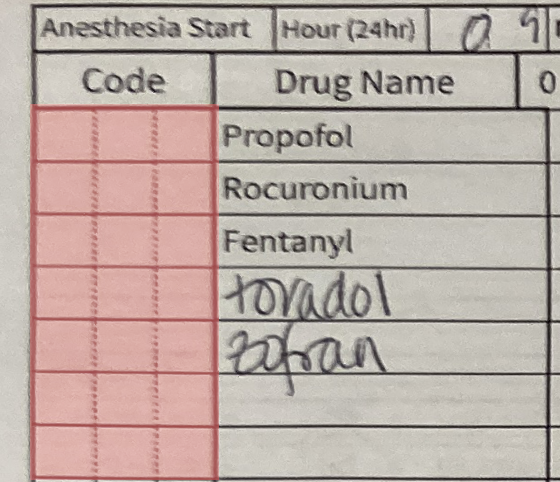

The code section, highlighted in red above, is an example of number boxes.

### 0.1 - Proposed Solution

Image registration works so well in the normal case that the locations of the number boxes should be very standardized.  
This allows us to find the centroids of a sample of every number box on the image post-registration, and match future handwritten number detections to a box by finding the number box centroid which has the minimum distance to the number detection.

## 1 - Load Data

### 1.0 - Import Packages

In [1]:
import sys
import os
sys.path.append(os.path.join("..", "..", "..", "ChartExtractor", "src"))

In [36]:
import cv2
import json
import numpy as np
from operator import attrgetter
from pathlib import Path
from PIL import Image, ImageDraw
import random
from typing import Dict, List, Tuple
from tqdm import tqdm
from utilities.annotations import BoundingBox, Point
from utilities.image_conversion import pil_to_cv2, cv2_to_pil

In [32]:
Point.__repr__ = lambda self: f"Point({self.x}, {self.y})" # todo: add a repr method to Point.
generate_color = lambda: "#%06x" % random.randint(0, 0xFFFFFF)

### 1.1 - Import and Wrangle Data

In [24]:
def label_studio_to_bboxes(path_to_json_data: Path) -> List[BoundingBox]:
    json_data: List[Dict] = json.loads(open(str(path_to_json_data)).read())
    return {
        sheet_data['data']['image'].split("-")[-1]:[
            BoundingBox(
                category=label['value']['rectanglelabels'][0],
                left=label['value']['x']/100,
                top=label['value']['y']/100,
                right=label['value']['x']/100+label['value']['width']/100,
                bottom=label['value']['y']/100+label['value']['height']/100,
            )
            for label in sheet_data['annotations'][0]['result']
        ]
        for sheet_data in json_data
    }


data_path: Path = Path("..")/".."/"data"
landmark_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"intraop_document_landmarks.json")
numbox_location_data: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"intraop_number_boxes.json")

In [14]:
def homography_transform(
    src_image: Image.Image,
    src_points: List[Tuple[float, float]],
    dest_points: List[Tuple[float, float]],
    original_image_size: Tuple[float, float] = (3300, 2250),
) -> Tuple[List[List[float]], Image.Image]:
    """Performs homography transformation on an image.

    This function transforms an image (src_image) based on corresponding points
    between the source and destination images. It calculates the homography matrix
    and uses it to warp the source image to the perspective of the destination points.

    Args:
        src_image (Image.Image):
            A PIL image object representing the source image.
        src_points (List[Tuple[int, int]]):
            A list of tuples (x, y) representing points in the source image that correspond
            to points in the destination image.
        dest_points (List[Tuple[int, int]]):
            A list of tuples (x, y) representing points in the destination image that points
            in the source image correspond to (where the source image should be warped to).
        original_image_size (Tuple[float, float]):
            A tuple (width, height) representing the size of the control image.
            Defaults to (3300, 2250).

    Returns:
        A PIL image object representing the transformed source image.

    Raises:
        ValueError:
            If the length of src_points and dest_points don't match (must have the same
            number of corresponding points), or if there are less than 4 points.
    """
    src_points: np.ndarray = np.array(src_points)
    dest_points: np.ndarray = np.array(dest_points)

    if len(src_points) != len(dest_points):
        raise ValueError(
            "Source and destination points must have the same number of elements."
        )
    if len(src_points) < 4 or len(dest_points) < 4:
        raise ValueError("Must have 4 or more points to compute the homography.")

    src_image = pil_to_cv2(src_image)
    h, _ = cv2.findHomography(src_points, dest_points)
    dest_image = cv2.warpPerspective(src_image, h, original_image_size)
    return h, cv2_to_pil(dest_image)

In [15]:
def get_corresponding_points(
    bboxes: List[BoundingBox], 
    imsize: Tuple[int, int],
    categories_to_get: List[str] = ['anesthesia_start', 'lateral', 'safety_checklist', 'units']
):
    """Gets the 'anesthesia_start', 'lateral', 'safety_checklist', and 'units' checkboxes
    from the list of bboxes.

    Args:
        bboxes (List[BoundingBox]):
            All the checkbox bounding boxes labeled by the name of the box they indicate.
        imsize (Tuple[int, int]):
            The size of the image.

    Returns:
        A list of tuples corresponding to the points 'anesthesia_start', 'lateral', 
        'safety_checklist', and 'units' BoundingBox centers. The list is sorted
        by the category names to maintain consistency.
    """
    points = list(map(
        attrgetter('center'),
        sorted(
            list(filter(lambda bb: bb.category in categories_to_get, bboxes)), 
            key=lambda bb: bb.category
        )
    ))
    return [(p[0]*imsize[0], p[1]*imsize[1]) for p in points]

In [17]:
remap_point = lambda p, h: cv2.perspectiveTransform(np.array(p, dtype=np.float32).reshape(-1, 1, 2), h).tolist()[0][0]


def remap_bbox(
    bbox: BoundingBox, 
    h, 
    original_width:int=4032, 
    original_height:int=3024,
    new_width:int=3300,
    new_height:int=2250,
) -> BoundingBox:
    """Applys the remap_point function to a BoundingBox.

    Args:
        bbox (BoundingBox):
            The bounding box to apply the homography to.
        h (np.ndarray):
            The homography matrix.
        original_width (int):
            The width of the original image.
        original_height (int):
            The height of the original image.
        new_width (int):
            The width of the destination image.
        new_height (int):
            The height of the destination image.

    Returns:
        A BoundingBox that has been remapped to the new image via the homography matrix.
    """
    new_left, new_top = remap_point((bbox.left*original_width, bbox.top*original_height), h)
    new_right, new_bottom = remap_point((bbox.right*original_width, bbox.bottom*original_height), h)
    return BoundingBox(bbox.category, new_left/new_width, new_top/new_height, new_right/new_width, new_bottom/new_height)


remap_all_bboxes = lambda bboxes, h: [remap_bbox(bb, h) for bb in bboxes]

In [29]:
landmark_names = [bb.category for bb in landmark_location_data["RC_0001_intraoperative.JPG"]]
singleton_landmark_names = list(filter(lambda bb_name: landmark_names.count(bb_name) == 1, landmark_names))
singleton_landmark_location_data = {
    k:list(filter(lambda bb: bb.category in singleton_landmark_names, v))
    for (k, v) in landmark_location_data.items()
}

remapped_data = dict()
remapped_numboxes = dict()
for im_name, boxes in tqdm(singleton_landmark_location_data.items()):
    if im_name=="unified_intraoperative_preoperative_flowsheet_v1_1_front.png":
        continue
    img = Image.open(str(data_path/"chart_images"/im_name))
    h, transformed_img = homography_transform(
        img, 
        get_corresponding_points(boxes, img.size),
        get_corresponding_points(singleton_landmark_location_data["unified_intraoperative_preoperative_flowsheet_v1_1_front.png"], (3300, 2250)),
    )
    remapped_boxes = remap_all_bboxes(boxes, h)
    try:
        remapped_cboxs = remap_all_bboxes(numbox_location_data[im_name], h)
    except:
        pass
    remapped_data[im_name] = remapped_boxes
    remapped_numboxes[im_name] = remapped_cboxs

100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


## 2 - Experiment

### 2.0 - Examine Locations of Datapoints

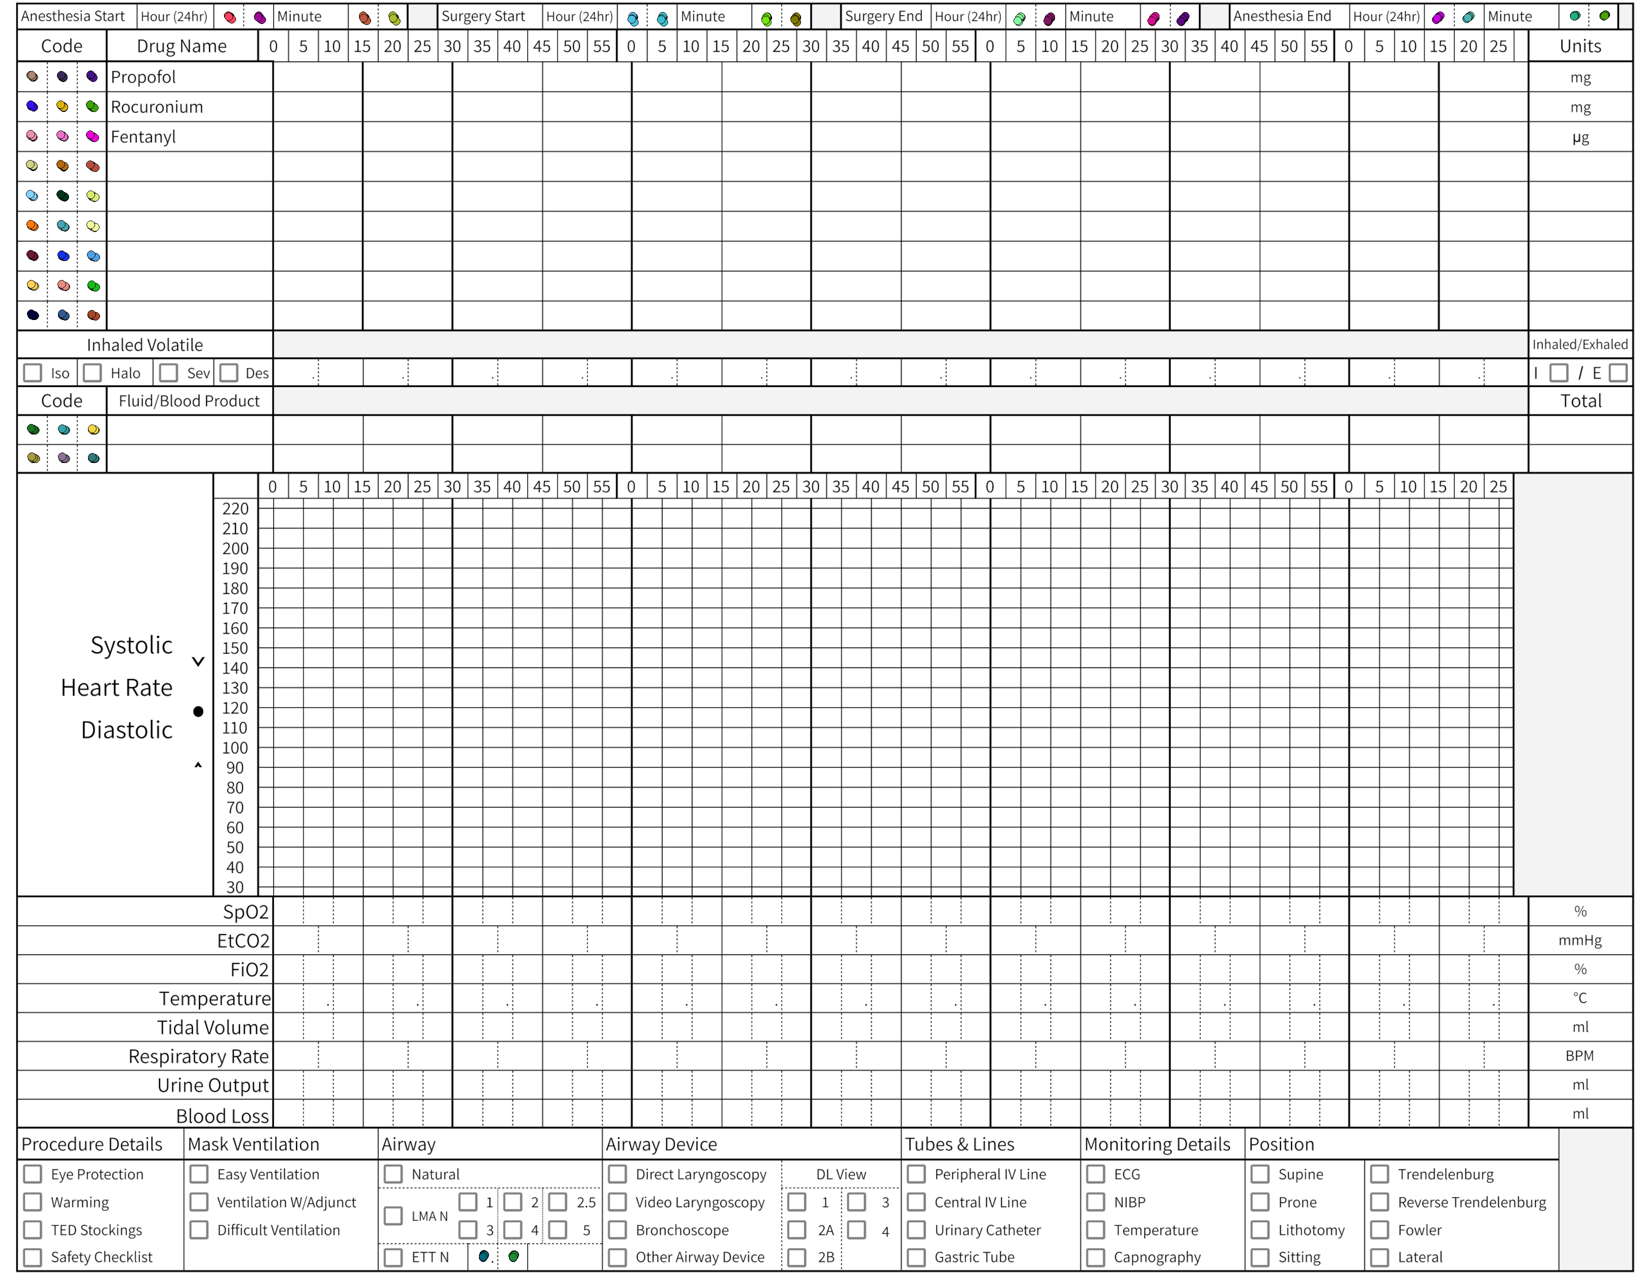

In [38]:
all_numboxes_list = [item for sublist in [v for v in remapped_numboxes.values()] for item in sublist]
numbox_names = list(set([bb.category for bb in all_numboxes_list]))
numbox_name_to_color_map = {name:generate_color() for name in numbox_names}

WIDTH, HEIGHT = 3300, 2250
im = Image.new(mode="RGB", size=(WIDTH, HEIGHT), color='white')
im = Image.open(data_path/"unified_intraoperative_preoperative_flowsheet_v1_1_front.png")
WIDTH, HEIGHT = im.size
draw = ImageDraw.Draw(im)
POINT_SIZE = 8
for numbox in all_numboxes_list:
    x, y = numbox.center
    x, y = x*WIDTH, y*HEIGHT
    draw.ellipse(
        (x-POINT_SIZE, y-POINT_SIZE, x+POINT_SIZE, y+POINT_SIZE),
        fill=numbox_name_to_color_map[numbox.category],
        outline="black"
    )
im.resize((WIDTH//2, HEIGHT//2))

## 2.1 - Finding Centroids

In [39]:
category_to_boxes_map = {
    category:list(filter(lambda numbx: numbx.category==category, all_numboxes_list))
    for category in list(set(c.category for c in all_numboxes_list))
}
centers = {
    category:[box.center for box in category_boxes]
    for (category, category_boxes) in category_to_boxes_map.items()
}
intraop_centroids = {
    category:(np.mean([c[0] for c in centers]), np.mean([c[1] for c in centers]))
    for (category, centers) in centers.items()
}

In [40]:
intraop_centroids

{'surg_end_hr_tens': (0.6176180022755308, 0.015278503574125947),
 'anes_end_min_tens': (0.9542628432765153, 0.012538828077372055),
 'ett_n_frac': (0.31126171398010744, 0.9854955283717105),
 'surg_start_min_ones': (0.48210404148132224, 0.014872488445705837),
 'surg_start_hr_tens': (0.38327809310986094, 0.014660948017187285),
 'code_row01_col0': (0.01917079274544115, 0.08271729300872624),
 'code_row00_col0': (0.01942217959171277, 0.05949021724232456),
 'code_row07_col2': (0.05596433028079677, 0.22384743388215003),
 'code_row02_col2': (0.05546253538968271, 0.10642912033705683),
 'code_row08_col2': (0.056058121944348394, 0.24705405573259323),
 'code_row02_col0': (0.019057947064510757, 0.10614207128335161),
 'code_row00_col1': (0.03754091174598706, 0.05948047927945679),
 'anes_end_hr_ones': (0.8898228403483851, 0.01356064486364175),
 'code_row08_col0': (0.019442880712627793, 0.24664226830911912),
 'code_row01_col2': (0.05538296542859724, 0.08299934949372945),
 'code_row04_col1': (0.03755233

In [43]:
with open("intraop_number_box_centroids.json", 'w') as file:
    file.write(json.dumps(intraop_centroids))

## 3 - Implementation

This implementation represents a more generalized version than that of the checkbox labeling.

In [45]:
# filepath consts will be changed in the real implementation.
FILEPATH_TO_INTRAOP_NUMBER_BOX_CENTROIDS = "intraop_number_box_centroids.json"
INTRAOP_NUMBER_BOX_CENTROIDS: Dict[str, Tuple[float, float]] = json.load(
    open(FILEPATH_TO_INTRAOP_NUMBER_BOX_CENTROIDS, 'r')
)


def match_boundingboxes_to_centroids(
    bounding_boxes: List[BoundingBox],
    centroids: Dict[str, Tuple[float, float]],
    threshold: float=0.025,
) -> Dict[str, str]:
    """Matches bounding boxes to the closest centroid.

    The bounding boxes must be the locations after image registration, or else they 
    will be incorrect due to the naive nature of this solution, which is to merely 
    find the closest bounding box based on the centroid of a sample of 10 ground-truth
    charts.
    
    Args:
        bounding_boxes (List[BoundingBox]):
            The BoundingBoxes to match.
        centroids (Dict[str, Tuple[float, float]]):
            The centroids of a sample of 10 checkboxes.
        threshold (float):
            The threshold that determines how far a centroid can be before it 
            is totally ruled out. If all centroids are more than the threshold away, 
            there is no associated name for that BoundingBox. Defaults to 2.5% of the
            image's width and height.

    Returns:
        A dictionary that maps the name of the centroid to the BoundingBox's category.
    """
    def distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
        """Computes euclidean distance."""
        return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

    bounding_box_values: Dict[str, str] = dict()
    for ckbx in bounding_boxes:
        distance_to_all_centroids: Dict[str, float] = {
            name:distance(ckbx.center, centroid)
            for (name, centroid) in centroids.items()
        }
        
        bbox_too_far_from_any_centroid: bool = all(
            [dist > threshold for dist in list(distance_to_all_centroids.values())]
        )
        if bbox_too_far_from_any_centroid:
            continue
        
        closest_bounding_box_centroid: str = min(
            distance_to_all_centroids, 
            key=distance_to_all_centroids.get
        )
        bounding_box_values[closest_bounding_box_centroid] = ckbx.category

    return bounding_box_values


def find_interaoperative_number_box_names(
    intraoperative_number_boxes: List[BoundingBox], 
    threshold: float=0.025
) -> Dict[str, str]:
    """Finds the names of intraoperative number boxes."""
    return match_boundingboxes_to_centroids(
        intraoperative_number_boxes, 
        INTRAOP_NUMBER_BOX_CENTROIDS, 
        threshold
    )